# Programatically understanding Adagrad

### Or Adagrad for linear regression from basics

In this post, I'll be using [Adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf) for solving linear regression. As usual, the purpose of this post is educational. [This link](http://ruder.io/optimizing-gradient-descent/) gives a good overview of Adagrad alongwith other variants of Gradient Descent. To summarise from the link:

>It adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters. For this reason, it is well-suited for dealing with sparse data. 

As I'd done previously, I'll be using [Autograd](https://github.com/HIPS/autograd) to compute the gradients. Please note Autograd and not Adagrad!

### Formulation ([borrowed from here]((http://ruder.io/optimizing-gradient-descent/)))

In regular gradient descent, we would update the $i^{th}$ parameter in the $t+1^{th}$ iteration, given the learning rate $\eta$, where $g_{t, i}$ represents the gradient of the cost wrt $i^{th}$ param at time $t$.

$$ \theta_{t+1, i} = \theta_{t, i} - \eta \cdot g_{t, i}  \tag{Eq 1} $$

In Adagrad, we update as follows:

$$\theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t, ii} + \epsilon}} \cdot g_{t, i} \tag{Eq 2}$$

Here, 

$G_{t} \in \mathbb{R}^{d \times d}$ is a diagonal matrix where each diagonal element $i, i$ is the sum of the squares of the gradients w.r.t. $\theta_i$ up to time step $t$ , while $\epsilon$ is a smoothing term that avoids division by zero (usually on the order of 1e−8). 

### Customary imports

In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### True model  

$$Y = 10 X + 6$$

### Generating data

In [2]:
np.random.seed(0)
n_samples = 50
X = np.linspace(1, 50, n_samples)
Y = 10*X + 6 + 2*np.random.randn(n_samples)

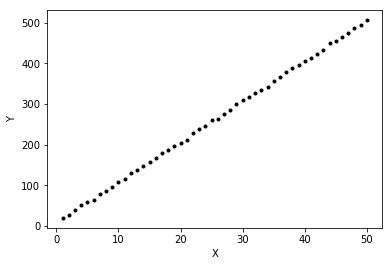

In [3]:
plt.plot(X, Y, 'k.')
plt.xlabel("X")
plt.ylabel("Y");

### Model to be learnt

We want to learn `W` and `b` such that:

$$Y = 10 W+ b$$

### Defining the cost function

We will now write a general cost function that accepts a list of parameters.

In [4]:
def cost(param_list):
    w, b = param_list
    pred = w*X+b
    return np.sqrt(((pred - Y) ** 2).mean(axis=None))/(2*len(Y))

### Dry run of cost and gradient functioning

In [5]:
# Cost of w=0, b=0
w, b = 0., 0.
print("Cost at w={}, b={} is: {}".format(w, b, cost([w, b])))

# Cost of w=10, b=4. Should be lower than w=0, b=0
w, b = 10., 4.
print("Cost at w={}, b={} is: {}".format(w, b, cost([w, b])))

# Computing the gradient at w=0, b=0
from autograd import grad
grad_cost =grad(cost)
w, b = 0., 0.
print("Gradient at w={}, b={} is: {}".format(w, b, grad_cost([w, b])))

# Computing the gradient at w=10, b=4. We would expect it to be smaller than at 0, 0
w, b = 10., 4.
print("Gradient at w={}, b={} is: {}".format(w, b, grad_cost([w, b])))

Cost at w=0.0, b=0.0 is: 2.98090446495
Cost at w=10.0, b=4.0 is: 0.0320479471939
Gradient at w=0.0, b=0.0 is: [array(-0.29297046699711365), array(-0.008765162440358071)]
Gradient at w=10.0, b=4.0 is: [array(-0.14406455246023858), array(-0.007117830452061141)]


### Adagrad algorithm (applied on whole data batch)

In [6]:
def adagrad_gd(param_init, cost, niter=5, lr=1e-2, eps=1e-8, random_seed=0):
    """
    param_init: List of initial values of parameters
    cost: cost function
    niter: Number of iterations to run
    lr: Learning rate
    eps: Fudge factor, to avoid division by zero
    """
    from copy import deepcopy
    import math
    # Fixing the random_seed
    np.random.seed(random_seed)
    
    # Function to compute the gradient of the cost function
    grad_cost = grad(cost)
    params = deepcopy(param_init)
    param_array, grad_array, lr_array, cost_array = [params], [], [[lr for _ in params]], [cost(params)]
    # Initialising sum of squares of gradients for each param as 0
    sum_squares_gradients = np.zeros(len(params))
    for i in range(niter):
        out_params = []
        gradients = grad_cost(params)
        # At each iteration, we add the square of the gradients to `sum_squares_gradients`
        sum_squares_gradients+= np.square(gradients)
        # Adapted learning rate for parameter list
        lrs = np.divide(lr, np.sqrt(sum_squares_gradients+eps))
        # Paramter update
        params = [param-(adapted_lr*grad_param) for param, adapted_lr, grad_param in zip(params, lrs, gradients)]
        param_array.append(params)
        lr_array.append(lrs)
        grad_array.append(gradients)
        cost_array.append(cost(params))
        
    return params, param_array, grad_array, lr_array, cost_array

### Experiment time!

#### Evolution of learning rates for `W` and `b`

Let us see how the learning rate for `W` and `b` will evolve over time. I will fix the initial learning rate to 0.01 as mot of the Adagrad literature out there seems to suggest.

In [7]:
# Fixing the random seed for reproducible init params for `W` and `b`
np.random.seed(0)
param_init = [np.random.randn(), np.random.randn()]
lr = 0.01
eps=1e-8
niter=1000
ada_params, ada_param_array, ada_grad_array, ada_lr_array, ada_cost_array = adagrad_gd(param_init, cost, niter=niter, lr=lr, eps=eps)

Let us first see the evolution of cost wrt time

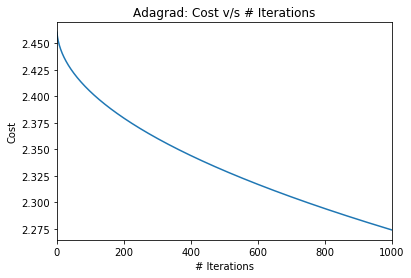

In [8]:
pd.Series(ada_cost_array, name='Cost').plot(title='Adagrad: Cost v/s # Iterations')
plt.ylabel("Cost")
plt.xlabel("# Iterations");

Ok. While There seems to be a drop in the cost, the converegence will be very slow. Remember that we had earlier found

>Cost at w=10.0, b=4.0 is: 0.0320479471939

I'm sure this means that our parameter estimates are similar to the initial parameters and far from the true parameters. Let's just confirm the same.

In [9]:
print("After {} iterations, learnt `W` = {} and learnt `b` = {}".format(niter, *ada_params))

After 1000 iterations, learnt `W` = 2.38206197991 and learnt `b` = 1.01815726317


I would suspect that the learning rate, courtesy of the adaptive nature is falling very rapidly! How would the vanilla gradient descent have done starting with the same learning rate and initial values? My hunch is it would do better. Let's  confirm!

#### GD vs Adagrad!

In [10]:
def gd(param_init, cost,  niter=5, lr=0.01, random_seed=0):
    np.random.seed(random_seed)
    from copy import deepcopy
    grad_cost = grad(cost)
    params = deepcopy(param_init)
    param_array, grad_array, cost_array = [params], [], [cost(params)]
    for i in range(niter):
        out_params = []
        gradients = grad_cost(params)
        params = [param-lr*grad_param for param, grad_param in zip(params, gradients)]
        param_array.append(params)
        grad_array.append(gradients)
        cost_array.append(cost(params))
    return params, param_array, grad_array, cost_array

In [11]:
# Fixing the random seed for reproducible init params for `W` and `b`
np.random.seed(0)
param_init = [np.random.randn(), np.random.randn()]
lr = 0.01
niter=1000
gd_params, gd_param_array, gd_grad_array, gd_cost = gd(param_init, cost, niter=niter, lr=lr)

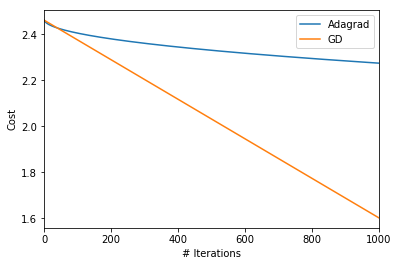

In [12]:
pd.Series(ada_cost_array, name='Cost').plot(label='Adagrad')
pd.Series(gd_cost, name='Cost').plot(label='GD')
plt.ylabel("Cost")
plt.xlabel("# Iterations")
plt.legend()

Ok. So, indeed with learning rate of 0.01, gradient descent fares better. Let's just confirm that for Adagrad, the learning rates diminish rapidly leading to little reduction in cost!

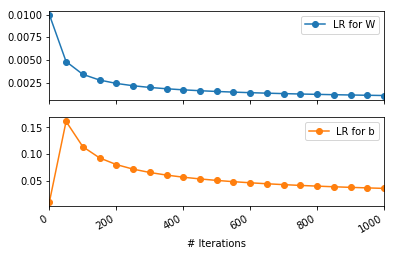

In [13]:
pd.DataFrame(np.array(ada_lr_array), columns=['LR for W', 'LR for b'])[::50].plot(subplots=True, marker='o')
plt.xlabel("# Iterations")

There are a couple of interesting observations:
    
1. The learning rate for `b` actually increases from its initial value of 0.01. Even after 1000 iterations, it remains more than its initial value. This can be explained by the fact that the suim of squares gradients wrt `b` would be less than 1. Thus, the denominator term by which the learning rate gets divided will be less than 1. Thus, increasing the learning rate wrt b. This can however be fixed by choosing $\epsilon=1.0$
2. The learning rate for `W` falls very rapidly. Learning would be negligble for `W` after the initial few iterations. This can be fixed by choosing a larger initial learning rate $\eta$.

#### Evolution of `W` and `b`, wrt $\eta$ and $\epsilon$

In [14]:
# Fixing the random seed for reproducible init params for `W` and `b`
out = {}
for lr in [0.01, 0.1, 1, 10]:
    out[lr] = {}
    for eps in [1e-8, 1e-1, 1]:
        print(lr, eps)
        np.random.seed(0)
        param_init = [np.random.randn(), np.random.randn()]
        niter=10000
        ada_params, ada_param_array, ada_grad_array, ada_lr_array, ada_cost_array = adagrad_gd(param_init,
                                                                                               cost, 
                                                                                               niter=niter,
                                                                                               lr=lr, 
                                                                                               eps=eps)
        out[lr][eps] = {'Final-params':ada_params,
                       'Param-array':ada_param_array,
                       'Cost-array':ada_cost_array}

(0.01, 1e-08)
(0.01, 0.1)
(0.01, 1)
(0.1, 1e-08)
(0.1, 0.1)
(0.1, 1)
(1, 1e-08)
(1, 0.1)
(1, 1)
(10, 1e-08)
(10, 0.1)
(10, 1)


##### Plotting cost v/s # Iterations

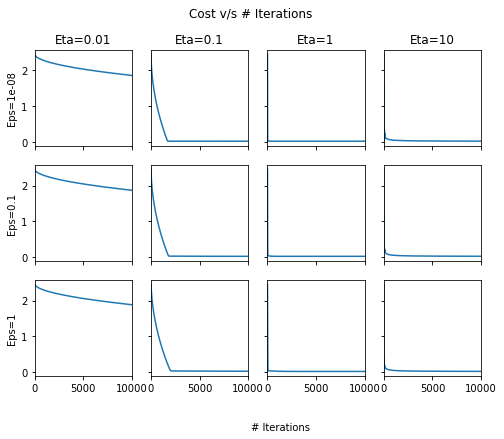

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, figsize=(8, 6), sharey=True)
for row, eps in enumerate([1e-8, 1e-1, 1]):
    for column, lr in enumerate([0.01, 0.1, 1, 10]):
        pd.Series(out[lr][eps]['Cost-array']).plot(ax=ax[row, column])
        ax[0, column].set_title("Eta={}".format(lr))
    ax[row, 0].set_ylabel("Eps={}".format(eps))
fig.text(0.5, 0.0, '# Iterations')
plt.suptitle("Cost v/s # Iterations");

It seems that choosing $\eta=1$ or above the cost usually converges quickly. This seems to be different from most literature recommending $\eta=0.01$. Aside: I confirmed that even using Tensorflow on the same dataset with Adagrad optimizer, the optimal learning rates are similar to the ones we found here!

##### `W` v/s # Iterations

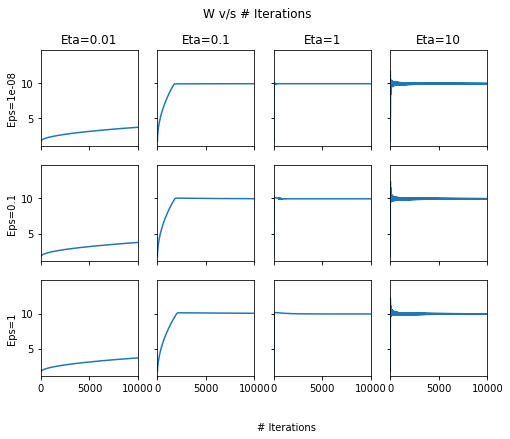

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, figsize=(8, 6), sharey=True)
for row, eps in enumerate([1e-8, 1e-1, 1]):
    for column, lr in enumerate([0.01, 0.1, 1, 10]):
        pd.DataFrame(out[lr][eps]['Param-array'])[0].plot(ax=ax[row, column])
        ax[0, column].set_title("Eta={}".format(lr))
    ax[row, 0].set_ylabel("Eps={}".format(eps))
fig.text(0.5, 0.0, '# Iterations')
plt.suptitle("W v/s # Iterations");

##### `b` v/s # Iterations

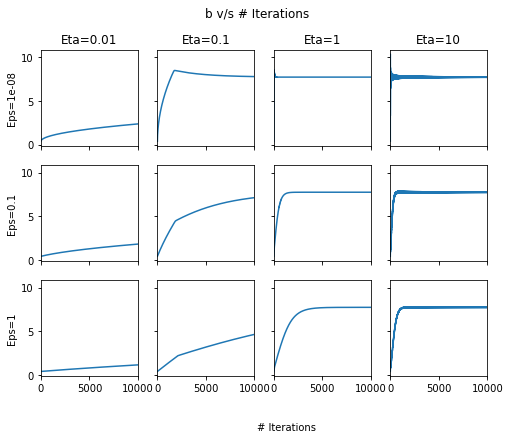

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, figsize=(8, 6), sharey=True)
for row, eps in enumerate([1e-8, 1e-1, 1]):
    for column, lr in enumerate([0.01, 0.1, 1, 10]):
        pd.DataFrame(out[lr][eps]['Param-array'])[1].plot(ax=ax[row, column])
        ax[0, column].set_title("Eta={}".format(lr))
    ax[row, 0].set_ylabel("Eps={}".format(eps))
fig.text(0.5, 0.0, '# Iterations')
plt.suptitle("b v/s # Iterations");

Across the above two plots, we can see that at high $\eta$, there are oscillations! In general, $\eta=1$ and $\epsilon=1e-8$ seem to give the best set of results.

#### Visualising the model learning

In [21]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, figsize=(8, 6), sharey=True)

def update(i):
    #fig.clf()
    for row, eps in enumerate([1e-8, 1e-1, 1]):
        for column, lr in enumerate([0.01, 0.1, 1, 10]):
            params_i =  out[lr][eps]['Param-array'][i]
            ax[row, column].cla()
            w_i, b_i = params_i
            ax[row, column].plot(X, Y, 'k.', ms=1)
            ax[row, column].plot(X, w_i*X+b_i, 'r')
            ax[row, column].tick_params( #https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
                axis='both',         
                which='both',      
                bottom='off', 
                left='off',
                top='off',         
                labelbottom='off',
                labelleft='off') 
            ax[0, column].set_title("Eta={}".format(lr))
        ax[row, 0].set_ylabel("Eps={}".format(eps))
    fig.suptitle("Iteration number: {}".format(i))

anim = FuncAnimation(fig, update, frames=np.arange(0, 5000, 200), interval=500)
anim.save('adagrad.gif', dpi=80, writer='imagemagick')
plt.close()

![](adagrad.gif)

So, there you go. Implementing Adagrad and running this experiment was a lot of fun and learning. Feel free to comment!